# Transformers库使用
1. Dataset使用
2. Transformers使用，以语音模型为例

In [1]:
# 导入库
# 其他常用库
import torch
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from tqdm import tqdm
import IPython.display as ipd

# Transformer库
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
from transformers import WhisperFeatureExtractor, WhisperModel
from transformers import WhisperProcessor, WhisperForConditionalGeneration
# Datasets库
from datasets import load_dataset, load_from_disk

from jiwer import wer

## Datasets库

In [7]:
# 从huggingface加载数据集
# ds = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation", cache_dir='/data/chenhonghua/datasets')
# ds.save_to_disk("/data/chenhonghua/datasets/librispeech_asr_dummy") # 保存数据集

In [3]:
# 从本地加载huggingface上保存下来的数据集
ds = load_from_disk("/data/chenhonghua/datasets/librispeech_test")
ds = ds['test.clean'] # 选择librispeech中的test clean数据集 
# ds = load_from_disk("/data/chenhonghua/datasets/librispeech_asr_dummy")
ds, ds[0] # 数据集结构

(Dataset({
     features: ['file', 'audio', 'text', 'speaker_id', 'chapter_id', 'id'],
     num_rows: 2620
 }),
 {'file': '/root/.cache/huggingface/datasets/downloads/extracted/e0f3d50e856945385982ba36b58615b72eef9b2ba5a2565bdcc225b70f495eed/6930-75918-0000.flac',
  'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/e0f3d50e856945385982ba36b58615b72eef9b2ba5a2565bdcc225b70f495eed/6930-75918-0000.flac',
   'array': array([-6.10351562e-05,  9.15527344e-05,  1.06811523e-03, ...,
          -2.19726562e-03, -1.13830566e-02, -8.81958008e-03]),
   'sampling_rate': 16000},
  'text': 'CONCORD RETURNED TO ITS PLACE AMIDST THE TENTS',
  'speaker_id': 6930,
  'chapter_id': 75918,
  'id': '6930-75918-0000'})

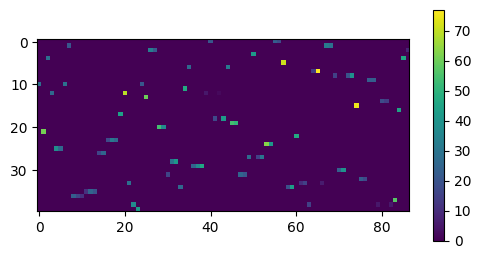

In [4]:
# 查看speaker和chapter属性
speaker = list(set(ds['speaker_id']))
chapter = list(set(ds['chapter_id']))
print(len(speaker), len(chapter))
data_matrix = np.zeros((len(speaker), len(chapter)))
for i in ds:
    data_matrix[speaker.index(i['speaker_id']), chapter.index(i['chapter_id'])] += 1
plt.figure(figsize=(6, 3))
plt.imshow(data_matrix)
plt.colorbar()

In [37]:
print(ds[0]['file']) # 指向原始文件的位置
print(ds[0]['text'])
ipd.Audio(ds[0]['audio']['array'], rate=16000)

/root/.cache/huggingface/datasets/downloads/extracted/e0f3d50e856945385982ba36b58615b72eef9b2ba5a2565bdcc225b70f495eed/6930-75918-0000.flac
CONCORD RETURNED TO ITS PLACE AMIDST THE TENTS


## Transformer库 Wav2vec2

In [3]:
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h").to("cuda")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
ds[0]["audio"]["array"].shape

(56080,)

In [5]:
processor(ds[0]["audio"]["array"], return_tensors="pt", padding="longest").input_values.to('cuda').shape

It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


torch.Size([1, 56080])

In [81]:
params = list(model.parameters()) #查看模型参数
state = model.state_dict()
for param in state:
    print(param, "\t\t", state[param].size())

wav2vec2.masked_spec_embed 		 torch.Size([768])
wav2vec2.feature_extractor.conv_layers.0.conv.weight 		 torch.Size([512, 1, 10])
wav2vec2.feature_extractor.conv_layers.0.layer_norm.weight 		 torch.Size([512])
wav2vec2.feature_extractor.conv_layers.0.layer_norm.bias 		 torch.Size([512])
wav2vec2.feature_extractor.conv_layers.1.conv.weight 		 torch.Size([512, 512, 3])
wav2vec2.feature_extractor.conv_layers.2.conv.weight 		 torch.Size([512, 512, 3])
wav2vec2.feature_extractor.conv_layers.3.conv.weight 		 torch.Size([512, 512, 3])
wav2vec2.feature_extractor.conv_layers.4.conv.weight 		 torch.Size([512, 512, 3])
wav2vec2.feature_extractor.conv_layers.5.conv.weight 		 torch.Size([512, 512, 2])
wav2vec2.feature_extractor.conv_layers.6.conv.weight 		 torch.Size([512, 512, 2])
wav2vec2.feature_projection.layer_norm.weight 		 torch.Size([512])
wav2vec2.feature_projection.layer_norm.bias 		 torch.Size([512])
wav2vec2.feature_projection.projection.weight 		 torch.Size([768, 512])
wav2vec2.feature_

In [6]:
result = model(processor(ds[0]["audio"]["array"], return_tensors="pt", padding="longest").input_values.to('cuda'))
result.logits.shape

It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


torch.Size([1, 175, 32])

In [21]:
import transformers as tf

In [23]:
tf.modeling_outputs.Wav2Vec2BaseModelOutput

transformers.modeling_outputs.Wav2Vec2BaseModelOutput

In [98]:
def map_to_pred(batch):
    array = batch["audio"]["array"]
    input_values = processor(array, return_tensors="pt", padding="longest", sampling_rate=16000).input_values
    with torch.no_grad():
        logits = model(input_values.to("cuda")).logits

    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.batch_decode(predicted_ids)
    batch["transcription"] = transcription
    return batch

result = ds.map(map_to_pred, batched=True, batch_size=1, remove_columns='audio')
#result = [map_to_pred(i) for i in tqdm(ds)]

Parameter 'function'=<function map_to_pred at 0x7fe435ef88c0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/2620 [00:00<?, ?ex/s]

In [101]:
# print("WER:", wer(result["text"], result["transcription"]))
print("WER:", wer([i["text"] for i in result], [i["transcription"][0] for i in result]))

WER: 0.03383673158855752


## Whisper

In [16]:
model = WhisperModel.from_pretrained("openai/whisper-base")
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-base")

In [17]:
data = [ds[i]["audio"]["array"] for i in range(3)]
inputs = feature_extractor(data, return_tensors="pt")
input_features = inputs.input_features

It is strongly recommended to pass the `sampling_rate` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


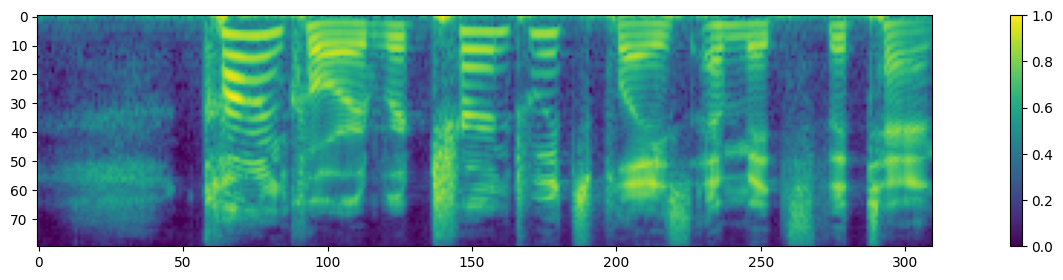

In [18]:
fig = plt.figure(figsize=(20, 3))
im = plt.imshow(input_features[0][:, :310])
fig.colorbar(mappable=None)
plt.show()

In [19]:
decoder_input_ids = torch.tensor([[1, 1]]) * model.config.decoder_start_token_id
result = model(input_features, decoder_input_ids=decoder_input_ids)
last_hidden_state = result.last_hidden_state

In [27]:
input_features[0].shape, ds[0]["audio"]["array"].shape, ds[0]["text"]

(torch.Size([80, 3000]),
 (56080,),
 'CONCORD RETURNED TO ITS PLACE AMIDST THE TENTS')

In [35]:
generated_ids = model.generate(inputs=input_features)
generated_ids.shape

/home/chenhonghua/anaconda3/envs/speech/lib/python3.7/site-packages/transformers-4.24.0-py3.7.egg/transformers/generation_utils.py:1364: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 448 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


torch.Size([1, 16])

In [36]:
transcription = processor.batch_decode(generated_ids, skip_special_tokens=True)
transcription

[' Concorde returned to its place amidst the tents.']

In [65]:
processor = WhisperProcessor.from_pretrained("openai/whisper-base")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-base").to('cuda')

In [60]:
input_features = processor(ds[0]["audio"]["array"], return_tensors="pt").input_features
input_features.shape

It is strongly recommended to pass the `sampling_rate` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


torch.Size([1, 80, 3000])

In [62]:
transcription = processor.batch_decode(model.generate(input_features), normalize = True)
transcription

/home/chenhonghua/anaconda3/envs/speech/lib/python3.7/site-packages/transformers-4.24.0-py3.7.egg/transformers/generation_utils.py:1364: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 448 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


['concorde returned to its place amidst the tents']

In [67]:
def map_to_pred(batch):
    input_features = processor(batch["audio"]["array"], return_tensors="pt").input_features

    with torch.no_grad():
        logits = model.generate(input_features.to("cuda"))
    # predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.batch_decode(logits, normalize = True)
    batch['text'] = processor.tokenizer._normalize(batch['text'])
    batch["transcription"] = transcription
    return batch
#result = ds.map(map_to_pred, batched=False, remove_columns='audio')
result = [map_to_pred(i) for i in tqdm(ds)]

  2%|▏         | 43/2620 [00:08<07:26,  5.77it/s]It is strongly recommended to pass the `sampling_rate` argument to this function. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to this function. Failing to do so can result in silent errors that might be hard to debug.
  2%|▏         | 55/2620 [00:10<08:26,  5.07it/s]It is strongly recommended to pass the `sampling_rate` argument to this function. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to this function. Failing to do so can result in silent errors that might be hard to debug.
  7%|▋         | 180/2620 [00:38<10:25,  3.90it/s]It is strongly recommended to pass the `sampling_rate` argument to this function. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the `sampling_rate` argument to this 

In [ ]:
print("WER:", wer(result["text"], result["transcription"]))

In [68]:
print("WER:", wer([i["text"] for i in result], [i["transcription"][0] for i in result]))

WER: 0.050427140890489754


## Layer-wise analysis

### 模型加载